### Preprocesamiento

In [1]:
import evaluate
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string

nltk.download('punkt_tab')
nltk.download('stopwords')

def preprocess_text(text):
    stop_words = set(stopwords.words('spanish'))
    punctution = set(string.punctuation)
    words_to_remove = stop_words.union(punctution)

    # Tokenize input
    word_tokens = word_tokenize(text, language='spanish')
    
    # Filter out stopwords
    filtered_words = [word for word in word_tokens if word.lower() not in words_to_remove]
    
    # Rejoin filtered words into a single string
    return ' '.join(filtered_words)


def f1(prediction, truth):
    pred_tokens = preprocess_text(prediction).split()
    truth_tokens = preprocess_text(truth).split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)

bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

[nltk_data] Downloading package punkt_tab to /home/matias/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/matias/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import pandas as pd

dataset = pd.read_csv('../data/qa_dataset_v2.csv')

references = dataset['Respuesta'].tolist()
predictions = dataset['Respuesta modelo'].tolist()

references_proc = [preprocess_text(ref) for ref in references]
predictions_proc = [preprocess_text(pred) for pred in predictions]

### Evaluación

In [5]:
from tqdm import tqdm 

scores = {'bleu': [], 'rouge': [], 'f1': []}

for ref, pred in tqdm(zip(references_proc, predictions_proc), total=len(references)):
    bleu_score = bleu.compute(references=[ref], predictions=[pred], tokenizer=lambda x:x)
    rouge_score = rouge.compute(references=[ref], predictions=[pred], tokenizer=lambda x:x)
    f1_score = f1(pred, ref)
    
    scores['bleu'].append(bleu_score)
    scores['rouge'].append(rouge_score)
    scores['f1'].append(f1_score)

scores['bertscore'] = bertscore.compute(references=references, predictions=predictions, lang='es')

100%|██████████| 198/198 [00:56<00:00,  3.50it/s]


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

### Resultados

In [6]:
print("Ejemplo de diferencia de scores usando método de evaluación contextual:\n")
print(references[1])
print(predictions[1])

print(f"""\nBLEU: {round(scores["bleu"][1]['bleu'], 2)}, ROUGE: {round(scores["rouge"][1]['rougeL'], 2)}, F1: {round(scores["f1"][1], 2)}, BERTScore F1: {round(scores["bertscore"]["f1"][1], 2)}""")

Ejemplo de diferencia de scores usando método de evaluación contextual:

Máximo Kirchner renunció porque consideraba que esta decisión facilitaría el trabajo de Alberto Fernández y le permitía expresar su desacuerdo con el entendimiento con el FMI.
La razón principal fue la falta de acuerdo con la estrategia utilizada y los resultados obtenidos en la negociación con el Fondo Monetario Internacional (FMI).

BLEU: 0.24, ROUGE: 0.42, F1: 0.07, BERTScore F1: 0.71


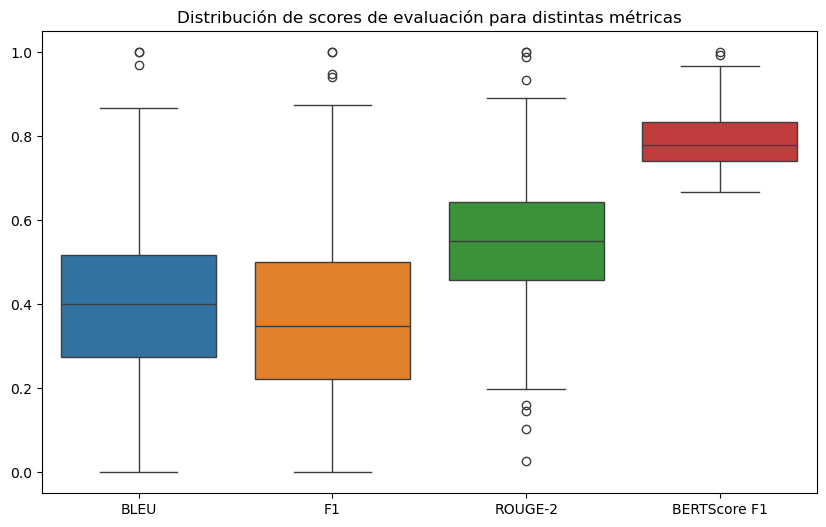

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

rouge_2_scores = [score['rouge2'] for score in scores['rouge']]
bert_f1_scores = scores['bertscore']['f1']
bleu_scores = [score['bleu'] for score in scores['bleu']]
f1_scores = scores['f1']

df = pd.DataFrame({'BLEU': bleu_scores, 'F1': f1_scores, 'ROUGE-2': rouge_2_scores, 'BERTScore F1': bert_f1_scores})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.title("Distribución de scores de evaluación para distintas métricas")
plt.savefig('../figures/eval_metrics_boxplot.png', dpi=300, bbox_inches='tight')